<div style="background-color:#3c3d41;padding:30px;border-radius:5px">

<h1 style="font-size:22px;color:white;margin-top:0px">
How to read and plot NASA MODIS L2 Active Fire Products using python ?
</h1>

<p style="font-size:14px;color:white">
Author: Benjamin Marchant<br>
License: CC BY 4.0
</p>
  
</div>

In [1]:
from matplotlib.pyplot import figure
from pyhdf.SD import SD, SDC 
from pyhdf.HDF import *
from pyhdf.VS import *
from datetime import date
from os import path

import pprint
import os
import glob
import random
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns; sns.set()
import numpy as np
import numpy.ma as ma
import pandas as pd
import cartopy.crs as ccrs
import pprint
import warnings

warnings.filterwarnings('ignore')

## File Name

In [2]:
file_name = "MYD14.A2019213.1200.061.2020302181517.hdf"

## Open HDF File

In [3]:
file = SD('./inputs/'+file_name, SDC.READ)

file_info = file.info()
print(file_info) 

(30, 32)


## Get SDS Names 

In [4]:
datasets_dic = file.datasets()

sds_dic = {}
for key, value in datasets_dic.items():
    #print key, value, value[3]
    sds_dic[value[3]] = key

pprint.pprint( sds_dic )

{0: 'fire mask',
 1: 'algorithm QA',
 2: 'FP_line',
 3: 'FP_sample',
 4: 'FP_latitude',
 5: 'FP_longitude',
 6: 'FP_R2',
 7: 'FP_T21',
 8: 'FP_T31',
 9: 'FP_MeanT21',
 10: 'FP_MeanT31',
 11: 'FP_MeanDT',
 12: 'FP_MAD_T21',
 13: 'FP_MAD_T31',
 14: 'FP_MAD_DT',
 15: 'FP_power',
 16: 'FP_AdjCloud',
 17: 'FP_AdjWater',
 18: 'FP_WinSize',
 19: 'FP_NumValid',
 20: 'FP_confidence',
 21: 'FP_land',
 22: 'FP_MeanR2',
 23: 'FP_MAD_R2',
 24: 'FP_ViewZenAng',
 25: 'FP_SolZenAng',
 26: 'FP_RelAzAng',
 27: 'FP_CMG_row',
 28: 'FP_CMG_col',
 29: 'CMG_day'}


## Get fire mask

In [5]:
sds_obj = file.select('fire mask') # select sds

fm_data = sds_obj.get() # get sds data

print( fm_data )

[[5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 [5 5 5 ... 5 5 5]
 ...
 [5 5 4 ... 4 4 4]
 [5 5 5 ... 4 4 4]
 [5 5 5 ... 4 4 4]]


Obtaining SDS attributes

In [6]:
pprint.pprint( sds_obj.attributes() )

{'legend': 'Classes:\n'
           '0 missing input data\n'
           '1 not processed (obsolete)\n'
           '2 not processed (obsolete)\n'
           '3 non-fire water\n'
           '4 cloud\n'
           '5 non-fire land\n'
           '6 unknown\n'
           '7 fire (low confidence)\n'
           '8 fire (nominal confidence)\n'
           '9 fire (high confidence)',
 'valid_range': [0, 9]}


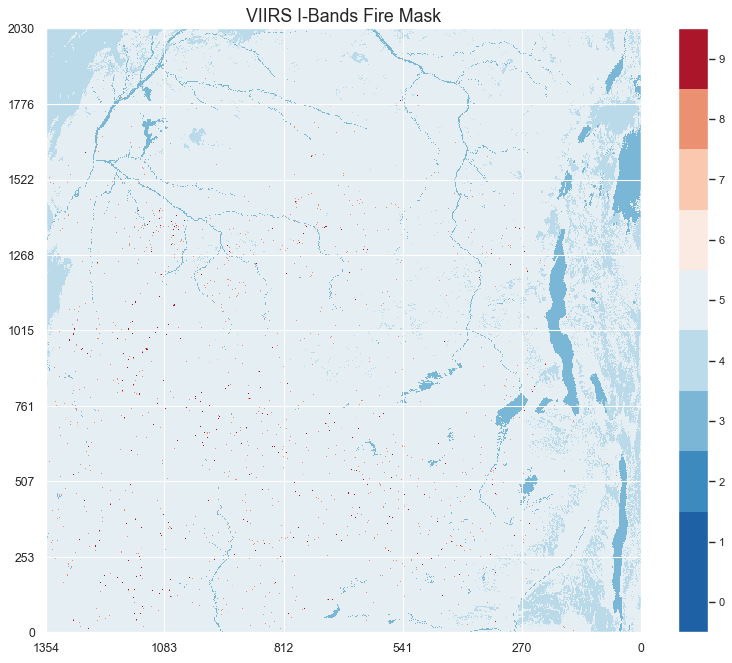

In [7]:
def plot_fire_mask(data):
    data_shape = data.shape
    figure(num=None, figsize=(12, 10), dpi=80, facecolor='w', edgecolor='k')
    cmap = sns.color_palette('RdBu_r', n_colors=10)
    cmap = mpl.colors.ListedColormap(cmap)
    bounds = [-0.5, 1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    img = plt.imshow(np.fliplr(data), cmap=cmap, norm=norm,interpolation='none', origin='lower', aspect='auto')
    cbar_bounds = [-0.5,0.5, 1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5]
    cbar_ticks = [0,1,2,3,4,5,6,7,8,9]               
    cbar = plt.colorbar(img, cmap=cmap, norm=norm, boundaries=cbar_bounds, ticks=cbar_ticks)
    cbar.ax.set_yticklabels(cbar_ticks, fontsize=10)
    plt.title('VIIRS I-Bands Fire Mask', fontsize=16)
    l = [int(i) for i in np.linspace(0,data_shape[1],6)]
    plt.xticks(l, [i for i in reversed(l)], rotation=0, fontsize=11 )
    l = [int(i) for i in np.linspace(0,data_shape[0],9)]
    plt.yticks(l, l, rotation=0, fontsize=11 )
    plt.xticks(fontsize=11)
    plt.yticks(fontsize=11)
    plt.show()
    return None

plot_fire_mask(fm_data)

In [8]:
fm_data[ fm_data > 6 ]

array([8, 8, 8, ..., 8, 8, 8], dtype=uint8)

## Algorithm QA

In [9]:
sds_obj = file.select('algorithm QA') # select sds

qa_data = sds_obj.get() # get sds data

print( qa_data )

[[22 22 22 ... 22 22 22]
 [22 22 22 ... 22 22 22]
 [22 22 22 ... 22 22 22]
 ...
 [22 22 22 ... 22 22 22]
 [22 22 22 ... 22 22 22]
 [22 22 22 ... 22 22 22]]


In [10]:
pprint.pprint( sds_obj.attributes() )

{'units': 'bit field'}


## Fire Pixels

In [11]:
sds_obj = file.select('FP_line') 

In [12]:
df_fire_pixels = pd.DataFrame()

if fm_data[ fm_data > 6 ].shape[0] > 0:

    for key, value in datasets_dic.items():

        if 'FP_' in key:

            sds_dic[value[3]] = key

            #print(key)

            sds_obj = file.select(key) # select sds

            #pprint.pprint( sds_obj.attributes() )

            data = sds_obj.get() # get sds data

            #print(data.shape)

            df_fire_pixels[key] = data
            
df_fire_pixels

,FP_line,FP_sample,FP_latitude,FP_longitude,FP_R2,FP_T21,FP_T31,FP_MeanT21,FP_MeanT31,FP_MeanDT,...,FP_NumValid,FP_confidence,FP_land,FP_MeanR2,FP_MAD_R2,FP_ViewZenAng,FP_SolZenAng,FP_RelAzAng,FP_CMG_row,FP_CMG_col
0,0,832,-16.452017,24.794563,0.216450,326.711487,309.906982,313.286926,308.977417,4.309494,...,12,53,1,0.233112,0.007194,14.070000,41.349998,-114.319992,425,819
1,0,876,-16.512472,24.352688,0.213322,320.538666,309.859863,312.595642,309.098694,3.496941,...,12,35,1,0.227703,0.006865,18.070000,41.160000,-114.329994,426,817
2,0,1085,-16.839336,21.861444,0.194579,323.899536,311.341766,314.978302,311.350464,3.627848,...,12,41,1,0.197271,0.015818,37.459999,40.160000,-112.599991,427,807
3,2,441,-15.889356,28.550121,0.186289,317.888702,305.293335,310.217926,304.524994,5.692952,...,22,41,1,0.209931,0.016734,21.350000,43.070000,59.130001,423,834
4,2,1049,-16.754778,22.356236,0.141419,329.157928,316.514130,318.598785,314.138672,4.460097,...,22,73,1,0.148297,0.022842,34.049999,40.329998,-113.379997,427,809
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8493,1901,1059,0.160423,18.742813,0.285033,308.857452,291.014648,300.987366,291.715973,9.271411,...,22,61,1,0.263379,0.026876,34.959999,25.359999,-125.459991,359,794
8494,1908,508,1.003631,24.124521,0.277960,320.300262,299.171143,305.107300,296.821808,8.285490,...,13,53,1,0.267220,0.012020,15.250000,28.830000,46.940002,355,816
8495,1919,1234,-0.071974,15.816005,0.284978,310.636383,289.944824,301.493103,288.462646,13.030457,...,22,69,1,0.306796,0.025761,52.110001,23.590000,-121.389999,360,783
8496,1932,948,0.628487,19.978615,0.256182,308.627411,288.138580,301.470642,289.117065,12.353574,...,22,49,1,0.254183,0.014966,24.639999,25.930000,-128.000000,357,799


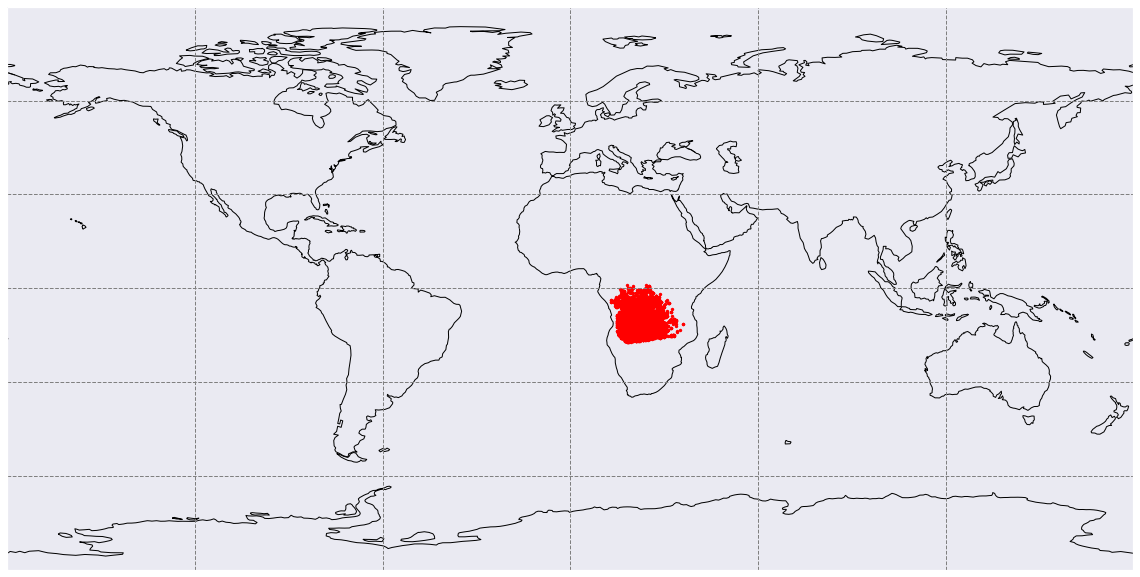

In [13]:
plt.figure(figsize=(16,9))

proj = ccrs.PlateCarree()

ease_extent = [-180., 180., 90., -90.]

ax = plt.axes(projection=proj)

ax.set_extent(ease_extent, crs=proj) 

ax.gridlines(color='gray', linestyle='--')

ax.coastlines()

longs = df_fire_pixels['FP_longitude']
lats = df_fire_pixels['FP_latitude']

plt.scatter( longs, lats,
         color='red', linewidth=2, marker='o', s=2,
         transform=ccrs.PlateCarree(),
         )

plt.tight_layout()

plt.show()

plt.close()

## Closing the file

In [14]:
file.end()

## References

- [MODIS Thermal Anomalies/Fire](https://modis.gsfc.nasa.gov/data/dataprod/mod14.php)
- [The collection 6 MODIS active fire detection algorithm and fire products](https://www.sciencedirect.com/science/article/pii/S0034425716300827)